# Tarefa 2-2: Redes Neurais Convolucionais e Normalização de Lote

Antes de começar, coloque seu nome e RA no seguinte formato

: Nome SOBRENOME, #000000   //   e.g.) Jurandy ALMEIDA, #123456

**Sua Resposta:**   
Sergio JUNIOR, #801814

# Código de Configuração
Antes de começar, precisamos executar algum código padrão para configurar nosso ambiente. Você precisará executar novamente este código de configuração sempre que iniciar o notebook.

Primeiro, execute esta célula para carregar a extensão [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload). Isso nos permite editar arquivos de origem `.py` e reimportá-los para o notebook para uma experiência de edição e depuração perfeita.

In [1]:
%load_ext autoreload
%autoreload 2

### Configuração do Google Colab
Em seguida, precisamos executar alguns comandos para configurar nosso ambiente no Google Colab. Se você estiver executando este notebook em uma máquina local, pode pular esta seção.

Execute a seguinte célula para montar seu Google Drive. Siga o link, entre na sua conta do Google (a mesma conta que você usou para armazenar este notebook!) E copie o código de autorização na caixa de texto que aparece abaixo.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Agora recorde o caminho em seu Google Drive onde você carregou este notebook, preencha-o abaixo. Se tudo estiver funcionando corretamente, a execução da célula a seguir deve imprimir os nomes dos arquivos da tarefa:

```
['t2_auxiliares.py', 'redes_convolucionais.ipynb', 'redes_convolucionais.py', 'redes_totalmente_conectadas.ipynb', 'redes_totalmente_conectadas.py', 'pi']
```

In [4]:
import os

# TODO: Preencha o caminho do Google Drive para onde você carregou a tarefa
# Exemplo: se você criar uma pasta PI-2022-1 e colocar todos os arquivos na pasta T2, então 'PI-2024-1/T2'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'PI-2024-1/T2'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'PI-2024-1/T2'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['t2_auxiliares.py', 'pi', '__pycache__', 'melhor_sobreajuste_rede_cinco_camadas.pt', 'melhor_rede_duas_camadas.pt', 'redes_totalmente_conectadas.ipynb', 'sobreajuste_rede_convolucional.pt', 'um_minuto_rede_convolucional.pt', 'redes_totalmente_conectadas.py', 'Sergio_801814_T2.zip', 'redes_convolucionais.py', 'redes_convolucionais.ipynb']


Depois de montar seu Google Drive com sucesso e localizar o caminho para esta tarefa, execute a seguinte célula para permitir a importação dos arquivos `.py` desta atribuição. Se funcionar corretamente, deve imprimir a mensagem:

```
Olá do redes_convolucionais.py!
Olá do t2_auxiliares.py!
```

bem como a última hora de edição do arquivo `redes_convolucionais.py`.

In [5]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from redes_convolucionais import ola_redes_convolucionais
ola_redes_convolucionais()

from t2_auxiliares import ola_auxiliar
ola_auxiliar()

redes_convolucionais_path = os.path.join(GOOGLE_DRIVE_PATH, 'redes_convolucionais.py')
redes_convolucionais_edit_time = time.ctime(os.path.getmtime(redes_convolucionais_path))
print('redes_convolucionais.py última edição em %s' % redes_convolucionais_edit_time)

Olá do redes_convolucionais.py!
Olá do t2_auxiliares.py!
redes_convolucionais.py última edição em Wed Aug 28 10:08:31 2024


# Pré-processamento dos dados

## Códigos de configuração
Execute alguns códigos de configuração para este notebook: Importe alguns pacotes úteis e aumente o tamanho da figura padrão.

In [6]:
import pi
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import random
import time
import math
%matplotlib inline

from pi import redefinir_semente, Solucionador

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

A partir desta tarefa, usaremos a GPU para acelerar nosso cálculo. Execute esta célula para certificar-se de que está usando uma GPU.

In [7]:
if torch.cuda.is_available:
  print('Pronto para continuar!')
else:
  print('Por favor, habilite a GPU em Edit -> Notebook Settings.')

Pronto para continuar!


## Carregue o conjunto de dados CIFAR-10
Em seguida, primeiro carregaremos o conjunto de dados CIFAR-10. A função de utilidade `pi.data.preprocessar_cifar10()` retorna o conjunto de dados CIFAR-10 como um conjunto de seis **tensores do Torch** enquanto também pré-processa as imagens RGB:

- `X_treino` contém todas as imagens de treino (números reais no intervalo $[0, 1]$)
- `y_treino` contém todos os rótulos de treino (inteiros no intervalo $[0, 9]$)
- `X_val` contém todas as imagens de validação
- `y_val` contém todos os rótulos de validação
- `X_teste` contém todas as imagens de teste
- `y_teste` contém todos os rótulos de teste

Podemos aprender mais sobre a função `pi.data.preprocessar_cifar10` invocando o comando` help`:

In [8]:
import pi
help(pi.data.preprocessar_cifar10)

Help on function preprocessar_cifar10 in module pi.data:

preprocessar_cifar10(cuda=True, exibir_amostras=True, truque_vies=False, achatado=True, taxa_validacao=0.2, dtype=torch.float32)
    Retorna uma versão pré-processada do conjunto de dados CIFAR10, automaticamente
    baixando se necessário. Realizamos as seguintes etapas:
    
    (0) [Opcional] Visualiza algumas imagens do conjunto de dados
    (1) Normaliza os dados subtraindo a média
    (2) [Opcional] Remodela cada imagem de forma (3, 32, 32) em um vetor de forma (3072,)
    (3) [Opcional] Truque do viés: adiciona uma dimensão extra de uns aos dados
    (4) Elabora um conjunto de validação do conjunto de treinamento
    
    Entrada:
    - cuda: se verdadeiro, move todo o conjunto de dados para a GPU
    - taxa_validacao: Real no intervalo (0, 1) indicando a fração do conjunto de 
      treinamento para reservar para validação
    - truque_vies: Booleano dizendo se deve ou não aplicar o truque do viés
    - achatado: Boolean

Agora podemos executar a função `pi.data.preprocess_cifar10` para obter nossos dados:

100%|██████████| 170498071/170498071 [00:04<00:00, 34773766.82it/s]


Extracting ./cifar-10-python.tar.gz to .


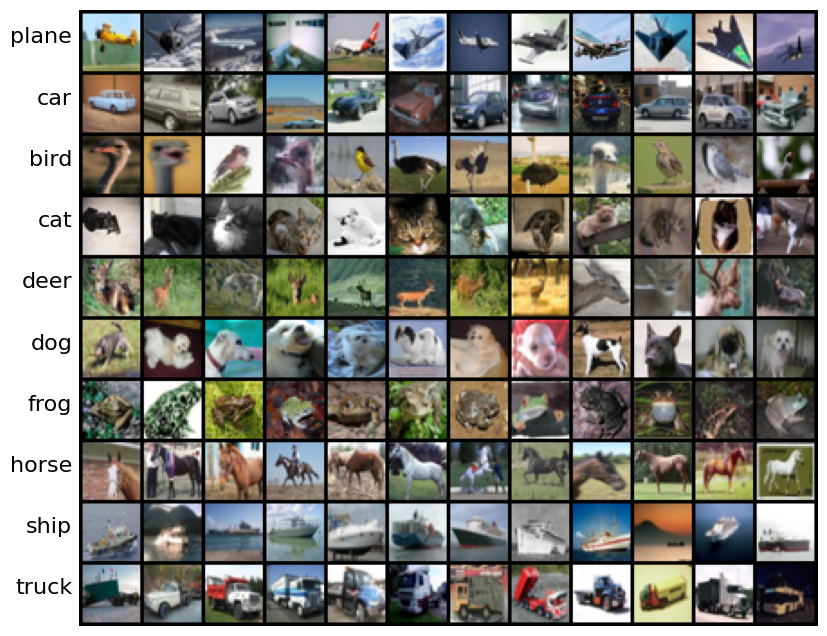

Dados de treinamento (shape):  torch.Size([40000, 3, 32, 32])
Rótulos de treinamento (shape):  torch.Size([40000])
Dados de validação (shape):  torch.Size([10000, 3, 32, 32])
Rótulos de valicação (shape):  torch.Size([10000])
Dados de teste (shape):  torch.Size([10000, 3, 32, 32])
Rótulos de teste (shape):  torch.Size([10000])


In [9]:
# Chame a rotina acima para obter nossos dados.
import pi

redefinir_semente(0)
dic_dados = pi.data.preprocessar_cifar10(dtype=torch.float32, achatado=False)
print('Dados de treinamento (shape): ', dic_dados['X_treino'].shape)
print('Rótulos de treinamento (shape): ', dic_dados['y_treino'].shape)
print('Dados de validação (shape): ', dic_dados['X_val'].shape)
print('Rótulos de valicação (shape): ', dic_dados['y_val'].shape)
print('Dados de teste (shape): ', dic_dados['X_teste'].shape)
print('Rótulos de teste (shape): ', dic_dados['y_teste'].shape)

# Redes convolucionais
Até agora, trabalhamos com redes totalmente conectadas, usando-as para explorar diferentes estratégias de otimização e arquiteturas de rede. Redes totalmente conectadas são um bom teste para experimentação porque são muito eficientes do ponto de vista computacional, mas na prática todos os resultados de última geração usam redes convolucionais.

Primeiro, veremos vários tipos de camadas que são usadas em redes convolucionais. Em seguida, você usará essas camadas para treinar uma rede convolucional no conjunto de dados CIFAR-10.

## Camada de convolução
No PyTorch, uma camada de convolução bidimensional é implementada pela classe [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d).

A classe `torch.nn.Conv2d()` espera que a entrada tenha shape `[tamanho_lote, canais_entrada, altura_entrada, largura_entrada]`.
Você pode verificar a lista completa de parâmetros na documentação do PyTorch. Os parâmetros necessários são:

- **in_channels** (*python: int*): Número de canais na entrada 2d, por exemplo. imagem.
- **out_channels** (*python: int*): Número de canais produzidos pela convolução.
- **kernel_size** (*python: int ou tuple*): Tamanho do filtro de convolução
- **stride** (*python: int ou tuple*): Tamanho do passo
- **padding** (*python: int ou tuple*): Quantidade de zeros implícitos em ambos os lados

<img src="https://drive.google.com/uc?export=download&id=1gwMuvJWtd4Cls3Ucma0xPKBY685LBh4r" width=100%>

<!-- ![](https://miro.medium.com/max/1400/0*zKUGeho8ljrTlS25)  -->

## Camada de agrupamento
No PyTorch, uma camada de agrupamento por máximo bidimensional é implementada pela classe [`torch.nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d).

A classe `torch.nn.MaxPool2d` espera que a entrada tenha shape `[tamanho_lote, canais_entrada, altura_entrada, largura_entrada]`.
Você pode verificar a lista completa de parâmetros na documentação do PyTorch. Os parâmetros necessários são:

- **kernel_size** (*python: int ou tuple*): Tamanho da janela de agrupamento
- **stride** (*python: int ou tuple*): Tamanho do passo
- **padding** (*python: int ou tuple*): Quantidade de zeros implícitos em ambos os lados

<img src="https://drive.google.com/uc?export=download&id=1h3OwHMinhu8CK8teHAVTBHFVVgcBlLLf" width=100%>

<!-- ![](https://cs231n.github.io/assets/cnn/maxpool.jpeg) -->

## À parte: Processamento de imagem via convoluções

Como forma divertida de entender melhor o tipo de operação que as camadas de convolução podem executar, configuraremos uma entrada contendo duas imagens e configuraremos manualmente filtros que executam operações comuns de processamento de imagem (conversão em escala de cinza e detecção de borda). O passo para frente da camada de convolução aplicará essas operações a cada uma das imagens de entrada. Podemos então visualizar os resultados como uma verificação de corretude.

<ipython-input-10-0a4e6f451615>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gatinho = imread(url_gatinho)
<ipython-input-10-0a4e6f451615>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  cachorro = imread(url_cachorro)


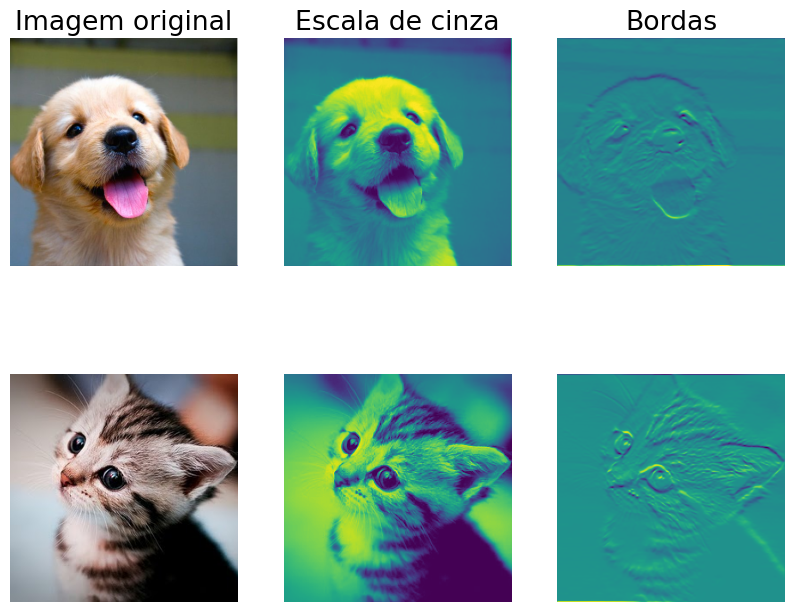

In [10]:
from imageio import imread
from PIL import Image
from torchvision.transforms import ToTensor

url_gatinho = 'https://drive.google.com/uc?export=download&id=1OqTpK4EvPEGBm5v3_Dmqi6jue-y-yaDn'
url_cachorro = 'https://drive.google.com/uc?export=download&id=143OLcwP3hM8D_UYWiTR0YPAVJ03DXZja'

gatinho = imread(url_gatinho)
cachorro = imread(url_cachorro)
# a imagem do gatinho é larga, e a do cachorro já é quadrada
d = gatinho.shape[1] - gatinho.shape[0]
gatinho_cortado = gatinho[:, d//2:-d//2, :]

tamanho_img = 200   # Reduza este tamanho se estiver muito lento
cachorro_escalado = ToTensor()(Image.fromarray(cachorro).resize((tamanho_img, tamanho_img)))
gatinho_escalado = ToTensor()(Image.fromarray(gatinho_cortado).resize((tamanho_img, tamanho_img)))
x = torch.stack([cachorro_escalado, gatinho_escalado])

# Configure pesos de uma camada de convolução com 2 filtros, 3x3 cada
w = torch.zeros(2, 3, 3, 3, dtype=x.dtype)

# O primeiro filtro converte a imagem em tons de cinza.
# Configure os canais vermelho, verde e azul do filtro.
w[0, 0, :, :] = torch.tensor([[0, 0, 0], [0, 0.3, 0], [0, 0, 0]])
w[0, 1, :, :] = torch.tensor([[0, 0, 0], [0, 0.6, 0], [0, 0, 0]])
w[0, 2, :, :] = torch.tensor([[0, 0, 0], [0, 0.1, 0], [0, 0, 0]])

# O segundo filtro detecta bordas horizontais no canal azul.
w[1, 2, :, :] = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# Vetor de viés. Não precisamos de viés para o filtro de conversão
# em tons de cinza, mas para o filtro de detecção de bordas queremos
# adicionar 128 a cada saída para que nada seja negativo.
b = torch.tensor([0, 128], dtype=x.dtype)

# Calcule o resultado da convolução de cada entrada em x com cada filtro
# em w, deslocando por b e armazenando os resultados em saida.
saida = torch.nn.functional.conv2d(x, w, bias=b, stride=1, padding=1)

def imshow_no_ax(img, normalizado=True):
  """ Função auxiliar para mostrar imagens como uint8 e remover rótulos de eixo """
  if normalizado:
    img_max, img_min = img.max(), img.min()
    img = 255.0 * (img - img_min) / (img_max - img_min)
  plt.imshow(img)
  plt.gca().axis('off')

# Mostre as imagens originais e os resultados da operação de conversão
plt.subplot(2, 3, 1)
imshow_no_ax(cachorro, normalizado=False)
plt.title('Imagem original')
plt.subplot(2, 3, 2)
imshow_no_ax(saida[0, 0])
plt.title('Escala de cinza')
plt.subplot(2, 3, 3)
imshow_no_ax(saida[0, 1])
plt.title('Bordas')
plt.subplot(2, 3, 4)
imshow_no_ax(gatinho_cortado, normalizado=False)
plt.subplot(2, 3, 5)
imshow_no_ax(saida[1, 0])
plt.subplot(2, 3, 6)
imshow_no_ax(saida[1, 1])
plt.show()

# Rede convolucional de três camadas
Agora que você conheceu todas as camadas necessárias, podemos colocá-las juntas em uma rede convolucional simples.

Conclua a implementação da classe `RedeConvTresCamadas`. Execute as seguintes células para ajudá-lo a depurar:

## Verificação da perda
Depois de construir uma nova rede, uma das primeiras coisas que você deve fazer é verificar a integridade da perda. Quando usamos a perda softmax, esperamos que a perda para pesos aleatórios (e sem regularização) seja cerca de $ln(C)$ para  $C$ categorias.

In [11]:
from redes_totalmente_conectadas import perda_softmax
from redes_convolucionais import RedeConvTresCamadas

redefinir_semente(0)
modelo = RedeConvTresCamadas()

N = 50
X = torch.randn(N, 3, 32, 32, dtype=torch.float32)
y = torch.randint(10, size=(N,), dtype=torch.int64)

pontuacoes = modelo(X)

perda = perda_softmax(pontuacoes, y)
print('Perda inicial (sem regularização): ', perda.item())

Perda inicial (sem regularização):  2.302584409713745


## Verificação de gradiente
Depois que a perda parecer razoável, use a verificação de gradiente numérica para garantir que seu passo para trás esteja correto. Ao usar a verificação de gradiente numérica, você deve usar uma pequena quantidade de dados artificiais e um pequeno número de neurônios em cada camada.

Você deve ver erros menores que `1e-5`.

In [12]:
from redes_convolucionais import RedeConvTresCamadas

num_entradas = 2
dims_entrada = (3, 16, 16)
reg = 0.0
num_classes = 10
redefinir_semente(0)
X = torch.randn(num_entradas, *dims_entrada, dtype=torch.float64)
y = torch.randint(num_classes, size=(num_entradas,), dtype=torch.int64)

modelo = RedeConvTresCamadas(num_filtros=3, tamanho_filtro=3,
                             dims_entrada=dims_entrada, dim_oculta=7,
                             escala_peso=5e-2).type(torch.float64)
perda = perda_softmax(modelo(X), y)
perda.backward() # calcula o gradiente

with torch.no_grad():
  for nome_param, param in sorted(modelo.named_parameters()):
    f = lambda _: perda_softmax(modelo(X), y)
    grad_num_param = pi.grad.calcular_gradiente_numerico(f, param)
    print('%s erro relativo max: %e' % (nome_param, pi.grad.erro_rel(grad_num_param, param.grad)))

conv1.bias erro relativo max: 3.724452e-08
conv1.weight erro relativo max: 3.348896e-08
fc1.bias erro relativo max: 2.900126e-08
fc1.weight erro relativo max: 5.963912e-08
fc2.bias erro relativo max: 1.667771e-09
fc2.weight erro relativo max: 1.239032e-08


## Sobreajuste um pequeno conjunto de dados
Um bom truque é treinar seu modelo com apenas algumas amostras de treinamento. Você deve ser capaz de sobreajustar pequenos conjuntos de dados, o que resultará em uma acurácia de treinamento muito alta e uma acurácia de validação comparativamente baixa.

In [13]:
from redes_totalmente_conectadas import perda_softmax
from redes_totalmente_conectadas import ConjuntoDeDados
from redes_convolucionais import RedeConvTresCamadas

redefinir_semente(0)

num_treino = 100
dados_pequeno = {
  'treinamento': ConjuntoDeDados(dic_dados['X_treino'][:num_treino],
                                 dic_dados['y_treino'][:num_treino]),
  'validacao': ConjuntoDeDados(dic_dados['X_val'], dic_dados['y_val']),
}

modelo = RedeConvTresCamadas(escala_peso=1e-3)
otimizador = torch.optim.Adam(modelo.parameters(), lr=2e-3)
solucionador = Solucionador(modelo, perda_softmax, otimizador, dados_pequeno,
                  imprime_cada=1, num_epocas=30, tamanho_lote=50,
                  device='cuda'
               )
estats = solucionador.treinar()

(Tempo 1.85 segundos; Iteração 1 / 60) perda: 2.302585
(Época 0 / 30) acurácia de treinamento: 13.00%; acurácia de validação: 10.16%
(Tempo 2.01 segundos; Iteração 2 / 60) perda: 2.301277
(Época 1 / 30) acurácia de treinamento: 16.00%; acurácia de validação: 10.15%
(Tempo 2.14 segundos; Iteração 3 / 60) perda: 2.290152
(Tempo 2.15 segundos; Iteração 4 / 60) perda: 2.272313
(Época 2 / 30) acurácia de treinamento: 16.00%; acurácia de validação: 10.14%
(Tempo 2.28 segundos; Iteração 5 / 60) perda: 2.222439
(Tempo 2.28 segundos; Iteração 6 / 60) perda: 2.237598
(Época 3 / 30) acurácia de treinamento: 16.00%; acurácia de validação: 10.14%
(Tempo 2.42 segundos; Iteração 7 / 60) perda: 2.155892
(Tempo 2.42 segundos; Iteração 8 / 60) perda: 2.217840
(Época 4 / 30) acurácia de treinamento: 23.00%; acurácia de validação: 12.71%
(Tempo 2.54 segundos; Iteração 9 / 60) perda: 2.192183
(Tempo 2.55 segundos; Iteração 10 / 60) perda: 2.088632
(Época 5 / 30) acurácia de treinamento: 29.00%; acurácia de

Plotar a perda, a acurácia de treinamento e a acurácia de validação deve mostrar claramente um sobreajuste:

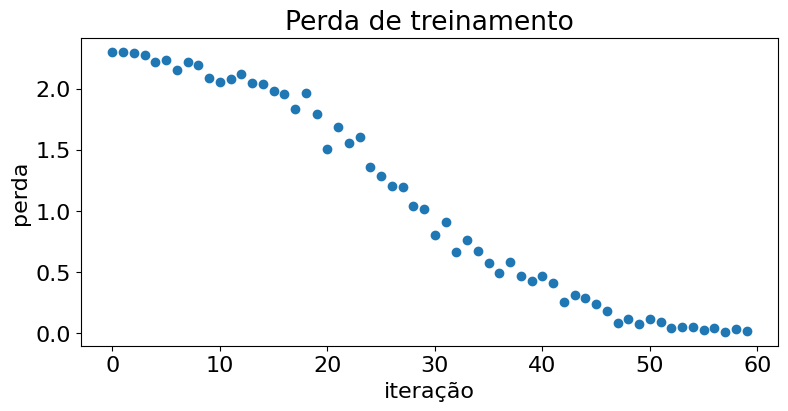

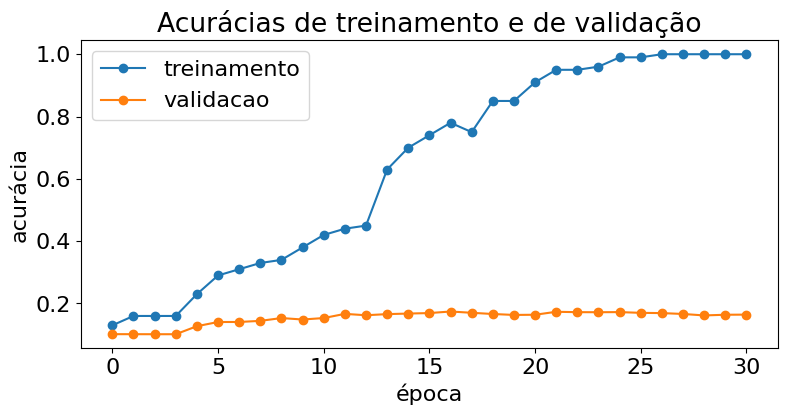

In [14]:
plt.title('Perda de treinamento')
plt.plot(solucionador.historico_perda, 'o')
plt.xlabel('iteração')
plt.ylabel('perda')
plt.gcf().set_size_inches(9, 4)
plt.show()

plt.title('Acurácias de treinamento e de validação')
plt.plot(solucionador.historico_acc_treinamento, '-o')
plt.plot(solucionador.historico_acc_validacao, '-o')
plt.legend(['treinamento', 'validacao'], loc='upper left')
plt.xlabel('época')
plt.ylabel('acurácia')
plt.gcf().set_size_inches(9, 4)
plt.show()

## Treine a rede
Ao treinar a rede convolucional de três camadas para uma época, você deve obter mais de 50% de acurácia no conjunto de treinamento:

In [15]:
from redes_totalmente_conectadas import perda_softmax
from redes_totalmente_conectadas import ConjuntoDeDados
from redes_convolucionais import RedeConvTresCamadas

redefinir_semente(0)

dados = {
  'treinamento': ConjuntoDeDados(dic_dados['X_treino'], dic_dados['y_treino']),
  'validacao': ConjuntoDeDados(dic_dados['X_val'], dic_dados['y_val']),
}

modelo = RedeConvTresCamadas(escala_peso=0.001, dim_oculta=500)
otimizador = torch.optim.Adam(modelo.parameters(), lr=2e-3, weight_decay=0.001)
solucionador = Solucionador(modelo, perda_softmax, otimizador, dados,
                  imprime_cada=50, num_epocas=1, tamanho_lote=64,
                  device='cuda'
               )
estats = solucionador.treinar()

(Tempo 0.05 segundos; Iteração 1 / 625) perda: 2.302585
(Época 0 / 1) acurácia de treinamento: 8.80%; acurácia de validação: 9.69%
(Tempo 0.47 segundos; Iteração 51 / 625) perda: 1.783778
(Tempo 0.69 segundos; Iteração 101 / 625) perda: 1.556189
(Tempo 0.91 segundos; Iteração 151 / 625) perda: 1.459280
(Tempo 1.13 segundos; Iteração 201 / 625) perda: 1.804351
(Tempo 1.34 segundos; Iteração 251 / 625) perda: 1.223698
(Tempo 1.56 segundos; Iteração 301 / 625) perda: 1.582827
(Tempo 1.78 segundos; Iteração 351 / 625) perda: 1.295493
(Tempo 2.00 segundos; Iteração 401 / 625) perda: 1.569459
(Tempo 2.22 segundos; Iteração 451 / 625) perda: 1.571500
(Tempo 2.44 segundos; Iteração 501 / 625) perda: 1.480780
(Tempo 2.67 segundos; Iteração 551 / 625) perda: 1.077971
(Tempo 2.91 segundos; Iteração 601 / 625) perda: 1.191712
(Época 1 / 1) acurácia de treinamento: 55.60%; acurácia de validação: 53.86%


## Visualize Filtros
Você pode visualizar os filtros de convolução da primeira camada da rede treinada executando o seguinte:

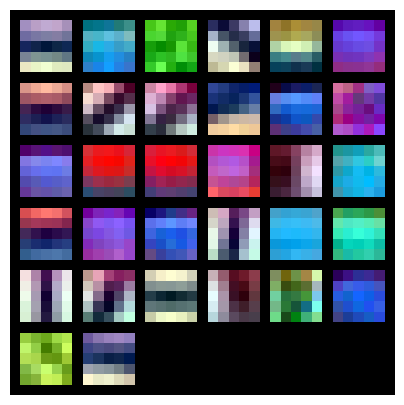

In [16]:
from torchvision.utils import make_grid
for _, camada in modelo.named_modules():
  if isinstance(camada, torch.nn.Conv2d):
    pesos = camada.weight.data
    break
nlinhas = math.ceil(math.sqrt(pesos.shape[0]))
grade = make_grid(pesos, nrow=nlinhas, padding=1, normalize=True, scale_each=True)
plt.imshow(grade.to(device='cpu').permute(1, 2, 0))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Rede convolucional profunda
Em seguida, você implementará uma rede convolucional profunda com um número arbitrário de camadas de convolução no estilo da rede VGG.

Leia a classe `RedeConvolucionalProfunda`.

Implemente a inicialização e o passo para frente. No momento, não se preocupe em implementar a normalização de lote; vamos adicionar esse recurso em breve.

## Verificação da perda
Depois de construir uma nova rede, uma das primeiras coisas que você deve fazer é verificar a integridade da perda. Quando usamos a perda softmax, esperamos que a perda para pesos aleatórios (e sem regularização) seja cerca de $ln(C)$ para  $C$ categorias.

In [17]:
from redes_totalmente_conectadas import perda_softmax
from redes_convolucionais import RedeConvProfunda

redefinir_semente(0)
dims_entrada = (3, 32, 32)
modelo = RedeConvProfunda(num_filtros=[8, 64],
                          agrups_max=[0, 1])

N = 50
X = torch.randn(N, *dims_entrada, dtype=torch.float32)
y = torch.randint(10, size=(N,), dtype=torch.int64)

pontuacoes = modelo(X)

perda = perda_softmax(pontuacoes, y)
print('Perda inicial (sem regularização): ', perda.item())

Perda inicial (sem regularização):  2.3025848865509033


## Verificação de gradiente
Depois que a perda parecer razoável, use a verificação de gradiente numérica para garantir que seu passo para trás esteja correto. Ao usar a verificação de gradiente numérica, você deve usar uma pequena quantidade de dados artificiais e um pequeno número de neurônios em cada camada.

Você deve ver erros relativos menores que `1e-5`.

In [18]:
from redes_totalmente_conectadas import perda_softmax
from redes_convolucionais import RedeConvProfunda

redefinir_semente(0)
num_entradas = 2
dims_entrada = (3, 8, 8)
num_classes = 10
X = torch.randn(N, *dims_entrada, dtype=torch.float64)
y = torch.randint(10, size=(N,), dtype=torch.int64)

modelo = RedeConvProfunda(dims_entrada=dims_entrada, num_classes=num_classes,
                          num_filtros=[8, 8, 8], agrups_max=[0, 2],
                          escala_peso=5e-2).type(torch.float64)

perda = perda_softmax(modelo(X), y)
perda.backward() # calcula o gradiente
# Os erros relativos devem ser da ordem de 1e-6
with torch.no_grad():
  for nome_param, param in sorted(modelo.named_parameters()):
    f = lambda _: perda_softmax(modelo(X), y)
    grad_num_param = pi.grad.calcular_gradiente_numerico(f, param)
    print('%s erro relativo max: %e' % (nome_param, pi.grad.erro_rel(grad_num_param, param.grad)))

camadas.0.bias erro relativo max: 4.945992e-07
camadas.0.weight erro relativo max: 8.823453e-07
camadas.1.bias erro relativo max: 1.022862e-07
camadas.1.weight erro relativo max: 5.981921e-07
camadas.2.bias erro relativo max: 5.555269e-08
camadas.2.weight erro relativo max: 6.061202e-07
camadas.3.bias erro relativo max: 1.239831e-08
camadas.3.weight erro relativo max: 4.195748e-07


## Sobreajuste um pequeno conjunto de dados
Como outra verificação de integridade, certifique-se de sobreajustar um pequeno conjunto de dados de 50 imagens. Na célula a seguir, ajuste a **taxa de aprendizado** e a **escala de inicialização de peso** para ajustar e atingir 100% de precisão de treinamento em 30 períodos.

(Tempo 0.22 segundos; Iteração 1 / 150) perda: 10.535071
(Época 0 / 30) acurácia de treinamento: 6.00%; acurácia de validação: 8.84%
(Época 1 / 30) acurácia de treinamento: 14.00%; acurácia de validação: 9.68%
(Época 2 / 30) acurácia de treinamento: 18.00%; acurácia de validação: 9.39%
(Tempo 1.21 segundos; Iteração 11 / 150) perda: 4.625829
(Época 3 / 30) acurácia de treinamento: 10.00%; acurácia de validação: 9.88%
(Época 4 / 30) acurácia de treinamento: 20.00%; acurácia de validação: 10.50%
(Tempo 2.03 segundos; Iteração 21 / 150) perda: 2.374612
(Época 5 / 30) acurácia de treinamento: 18.00%; acurácia de validação: 10.92%
(Época 6 / 30) acurácia de treinamento: 28.00%; acurácia de validação: 10.78%
(Tempo 2.46 segundos; Iteração 31 / 150) perda: 2.337648
(Época 7 / 30) acurácia de treinamento: 30.00%; acurácia de validação: 10.27%
(Época 8 / 30) acurácia de treinamento: 36.00%; acurácia de validação: 10.76%
(Tempo 2.78 segundos; Iteração 41 / 150) perda: 2.108405
(Época 9 / 30) acu

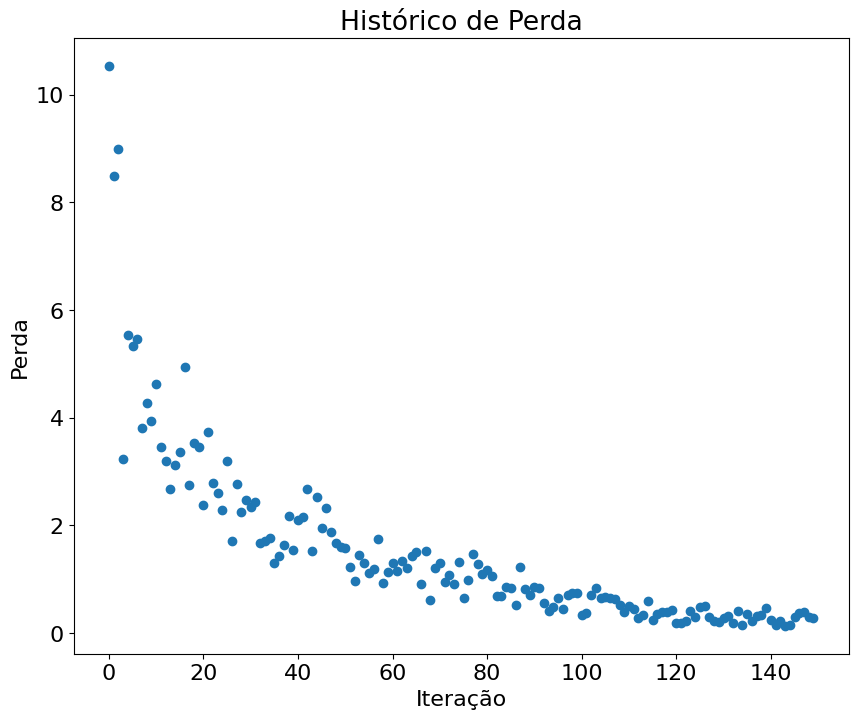

A acurácia no subconjunto de treinamento é: 100.00%


In [19]:
from redes_totalmente_conectadas import perda_softmax
from redes_totalmente_conectadas import ConjuntoDeDados
from redes_convolucionais import RedeConvProfunda
from redes_convolucionais import encontrar_parametros_sobreajuste

# TODO: Use uma rede convolucional profunda para sobreajustar 50 exemplos de
# treinamento ajustando a taxa de aprendizado e escala de inicialização de peso.
redefinir_semente(0)

num_treino = 50
dados_pequeno = {
  'treinamento': ConjuntoDeDados(dic_dados['X_treino'][:num_treino],
                                 dic_dados['y_treino'][:num_treino]),
  'validacao': ConjuntoDeDados(dic_dados['X_val'], dic_dados['y_val']),
}
dims_entrada = dic_dados['X_treino'].shape[1:]

# Atualize os parâmetros em encontrar_parametros_de_sobreajuste
escala_peso, taxa_aprendizagem = encontrar_parametros_sobreajuste()

modelo = RedeConvProfunda(dims_entrada=dims_entrada,
                          num_classes=10,
                          num_filtros=[8, 16, 32, 64],
                          agrups_max=[0, 1, 2, 3],
                          escala_peso=escala_peso)
otimizador = torch.optim.Adam(modelo.parameters(), lr=taxa_aprendizagem, weight_decay=1e-5)
solucionador = Solucionador(modelo, perda_softmax, otimizador, dados_pequeno,
                  imprime_cada=10, num_epocas=30, tamanho_lote=10,
                  device='cuda'
               )

# Ajuste retornar_melhores_parametros para permitir que os parâmetros finais
# sejam salvos, em vez dos melhores pesos no conjunto de validação.
estats = solucionador.treinar(retornar_melhores_parametros=False)

plt.plot(solucionador.historico_perda, 'o')
plt.title('Histórico de Perda')
plt.xlabel('Iteração')
plt.ylabel('Perda')
plt.show()

# Avalia no subconjunto de treinamento
acuracia = solucionador.verificar_acuracia(solucionador.treinamento)
print('A acurácia no subconjunto de treinamento é: %.2f%%' % float(100.0 * acuracia))

Se você estiver satisfeito com o desempenho do modelo, execute a seguinte célula para salvá-lo.
Também vamos recarregar o modelo e executá-lo nos dados de treinamento para verificar se estão nos pesos corretos.

In [20]:
# Salva o melhor modelo
path = os.path.join(GOOGLE_DRIVE_PATH, 'sobreajuste_rede_convolucional.pt')
torch.save(solucionador.modelo.state_dict(), path)

# Cria uma nova instância
modelo = RedeConvProfunda(dims_entrada=dims_entrada,
                          num_classes=10,
                          num_filtros=[8, 16, 32, 64],
                          agrups_max=[0, 1, 2, 3],
                          escala_peso=escala_peso)
solucionador = Solucionador(modelo, perda_softmax, otimizador, dados_pequeno,
                  imprime_cada=10, num_epocas=30, tamanho_lote=10,
                  device='cuda'
               )


# Carrega o modelo
solucionador.modelo.load_state_dict(torch.load(path))

# Avalia no subconjunto de treinamento
acuracia = solucionador.verificar_acuracia(solucionador.treinamento)
print('A acurácia do modelo salvo no subconjunto de treinamento é: %.2f%%' % float(100.0 * acuracia))

A acurácia do modelo salvo no subconjunto de treinamento é: 100.00%


<ipython-input-20-525d203e8b5c>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  solucionador.modelo.load_state_dict(torch.load(path))


# Inicialização Kaiming
Até agora, você ajustou manualmente a escala de pesos e para inicialização dos pesos.
No entanto, isso é ineficiente quando se trata de treinar redes neurais profundas; praticamente, como sua matriz de pesos é maior, a escala de pesos deve ser pequena.

No PyTorch, uma alternativa é usar a [inicialização Kaiming](http://arxiv-web3.library.cornell.edu/abs/1502.01852), a qual está implementada na classe [`torch.nn.init.kaiming_normal_`](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_). Para mais detalhes, consulte as [notas de aula do curso CS231n](http://cs231n.github.io/neural-networks-2/#init) e a [documentação do PyTorch](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_).

# Redes convolucionais com inicialização Kaiming
Agora que você conhece a inicialização  Kaiming, volte para a sua implementação de [`RedeConvProfunda`](#scrollTo=JleotK9yDcyv). Modifique sua implementação para adicionar a inicialização Kaiming.

Concretamente, quando `escala_peso` for definido como `'kaiming'` no construtor, você deve inicializar os pesos das camadas de convolução e lineares usando a classe `torch.nn.init.kaiming_normal_`. Quando terminar, execute o seguinte para ver o efeito da inicialização Kaiming em CNNs profundas.

Neste experimento, treinamos uma rede de 31 camadas com quatro esquemas diferentes de inicialização de pesos. Entre eles, apenas o método de inicialização Kaiming deve atingir uma acurácia não aleatória após uma época de treinamento.

Você pode ver uma perda igual à `nan` quando `escala_peso` for grande, o que mostra a catástrofe de uma inicialização de pesos inapropriada.

In [21]:
from redes_totalmente_conectadas import perda_softmax
from redes_totalmente_conectadas import ConjuntoDeDados
from redes_convolucionais import RedeConvProfunda

redefinir_semente(0)

# Tente treinar uma rede convolucional profunda com diferentes métodos de inicialização de peso
num_treino = 10000
dados_pequeno = {
  'treinamento': ConjuntoDeDados(dic_dados['X_treino'][:num_treino],
                                 dic_dados['y_treino'][:num_treino]),
  'validacao': ConjuntoDeDados(dic_dados['X_val'], dic_dados['y_val']),
}
dims_entrada = dic_dados['X_treino'].shape[1:]

escalas_peso = ['kaiming', 1e-1, 1e-2, 1e-3]

solucionadores = []
for escala_peso in escalas_peso:
  print('Solucionador com escala de pesos: ', escala_peso)
  modelo = RedeConvProfunda(dims_entrada=dims_entrada,
                            num_classes=10,
                            num_filtros=([8] * 10) + ([32] * 10) + ([128] * 10),
                            agrups_max=[9, 19],
                            escala_peso=escala_peso)
  otimizador = torch.optim.SGD(modelo.parameters(), lr=2e-3, weight_decay=1e-5, momentum=0.9)
  solucionador = Solucionador(modelo, perda_softmax, otimizador, dados_pequeno,
                  imprime_cada=20, num_epocas=1, tamanho_lote=128,
                  device='cuda'
               )
  solucionador.treinar()
  solucionadores.append(solucionador)

Solucionador com escala de pesos:  kaiming
(Tempo 0.10 segundos; Iteração 1 / 79) perda: 2.306919
(Época 0 / 1) acurácia de treinamento: 9.10%; acurácia de validação: 10.24%
(Tempo 1.53 segundos; Iteração 21 / 79) perda: 2.303032
(Tempo 2.15 segundos; Iteração 41 / 79) perda: 2.291724
(Tempo 2.78 segundos; Iteração 61 / 79) perda: 2.280985
(Época 1 / 1) acurácia de treinamento: 21.80%; acurácia de validação: 21.09%
Solucionador com escala de pesos:  0.1
(Tempo 0.03 segundos; Iteração 1 / 79) perda: 16.260876
(Época 0 / 1) acurácia de treinamento: 9.50%; acurácia de validação: 9.52%
(Tempo 1.30 segundos; Iteração 21 / 79) perda: nan
(Tempo 1.90 segundos; Iteração 41 / 79) perda: nan
(Tempo 2.50 segundos; Iteração 61 / 79) perda: nan
(Época 1 / 1) acurácia de treinamento: 11.30%; acurácia de validação: 10.14%
Solucionador com escala de pesos:  0.01
(Tempo 0.03 segundos; Iteração 1 / 79) perda: 2.302585
(Época 0 / 1) acurácia de treinamento: 11.40%; acurácia de validação: 10.16%
(Tempo 1.

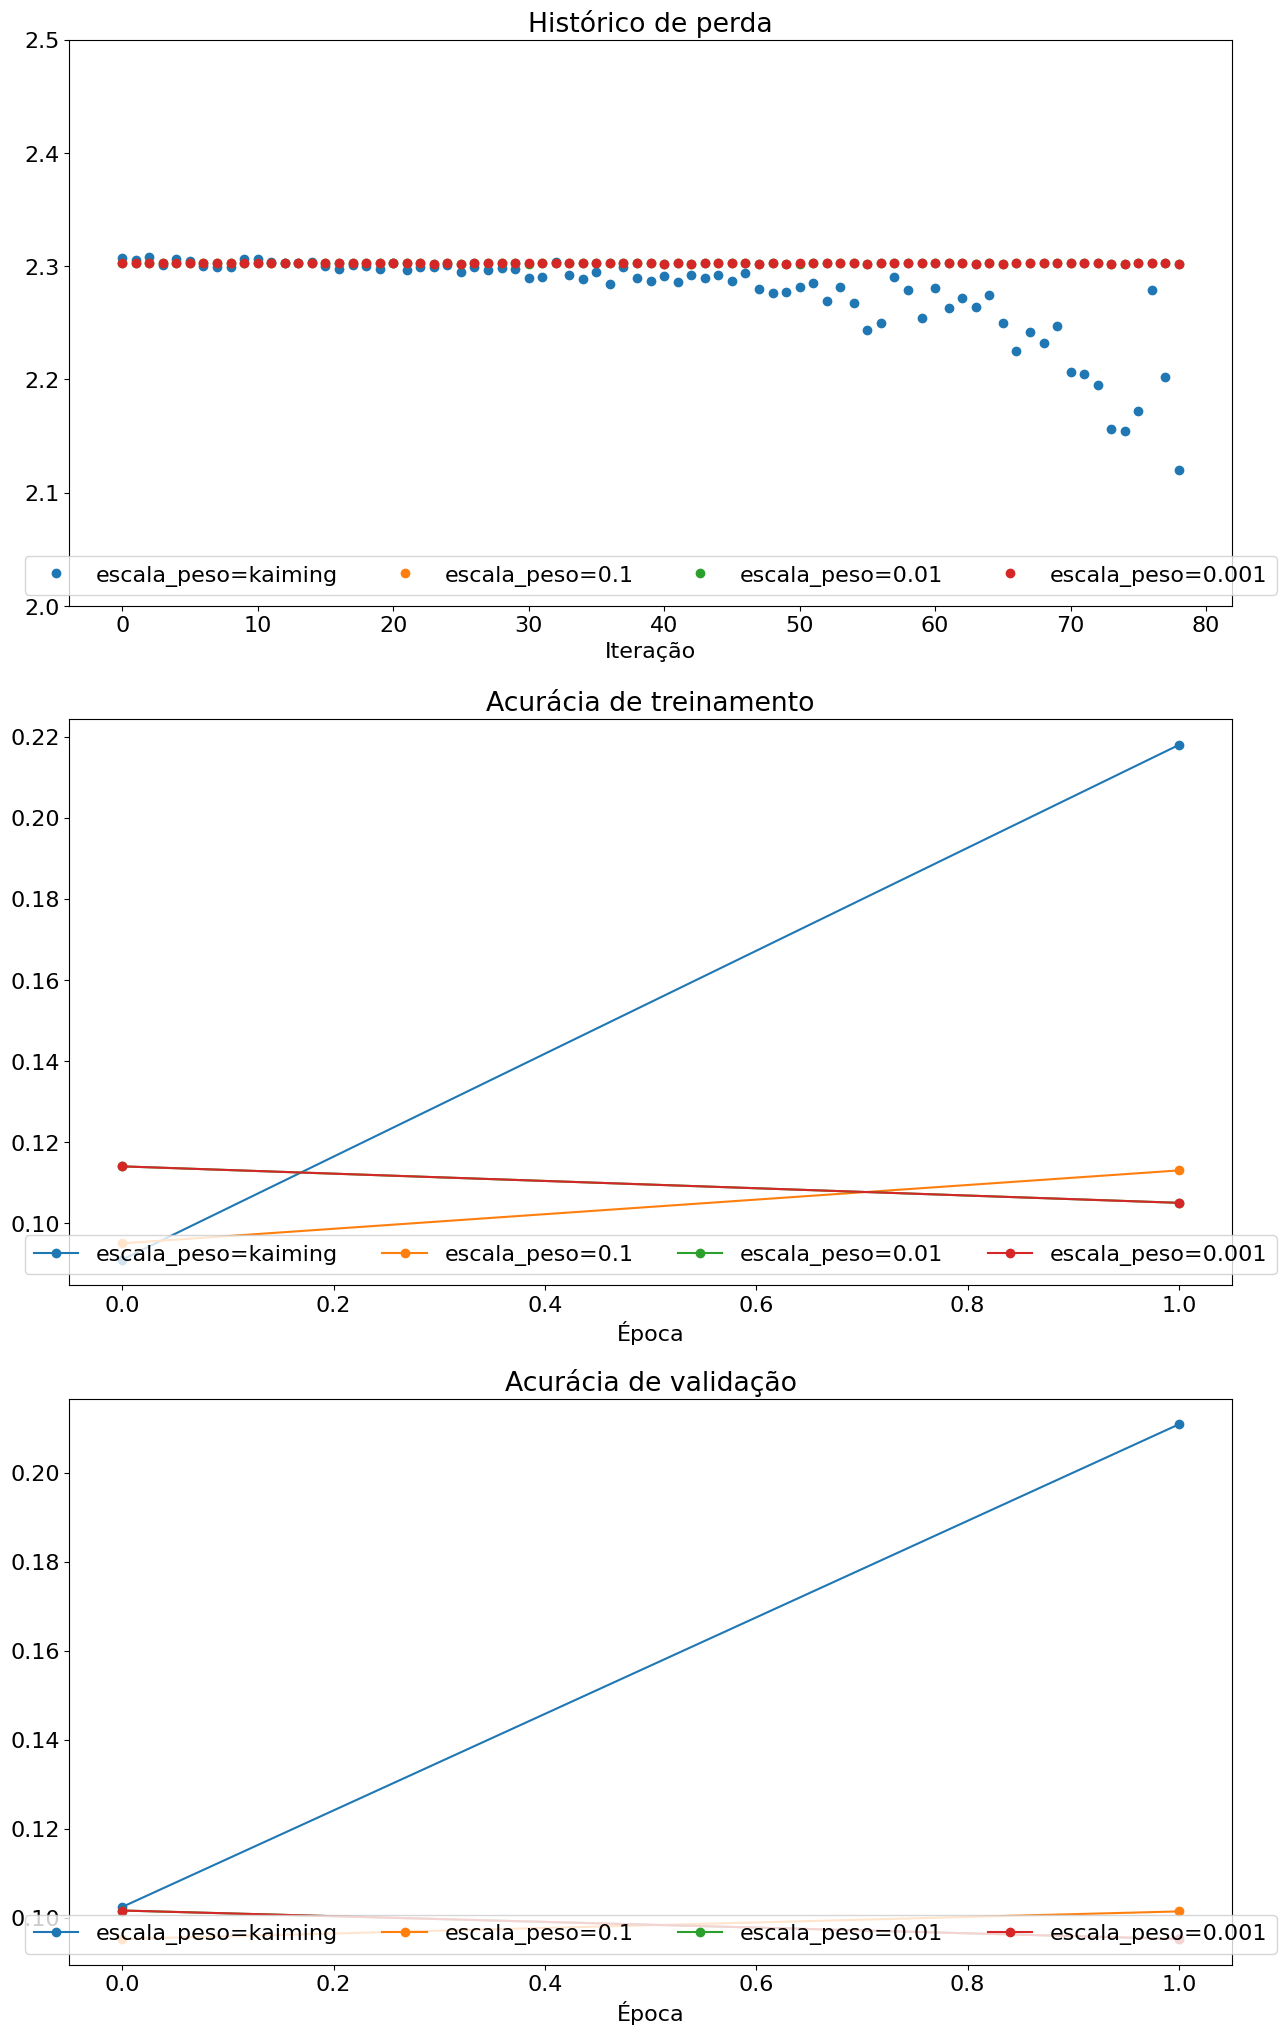

In [22]:
def plotar_historico_treinamento_ini(titulo, eixo_x, solucionadores, escalas_peso, fn_plot, marker='-o'):
  plt.title(titulo)
  plt.xlabel(eixo_x)
  for solucionador, escala_peso in zip(solucionadores, escalas_peso):
    data = fn_plot(solucionador)
    label = 'escala_peso=' + str(escala_peso)
    plt.plot(data, marker, label=label)
  plt.legend(loc='lower center', ncol=len(solucionadores))

plt.subplot(3, 1, 1)
plotar_historico_treinamento_ini('Histórico de perda','Iteração', solucionadores, escalas_peso,
                            lambda x: x.historico_perda, marker='o')
plt.ylim(2.0, 2.5)
plt.subplot(3, 1, 2)
plotar_historico_treinamento_ini('Acurácia de treinamento','Época', solucionadores, escalas_peso,
                           lambda x: x.historico_acc_treinamento)
plt.subplot(3, 1, 3)
plotar_historico_treinamento_ini('Acurácia de validação','Época', solucionadores, escalas_peso,
                           lambda x: x.historico_acc_validacao)
plt.gcf().set_size_inches(15, 25)
plt.show()

# Treine um bom modelo!
Treine o melhor modelo convolucional que puder no CIFAR-10, armazenando seu melhor modelo na variável `melhor_modelo`. Exigimos que você obtenha pelo menos 71% de acurácia no conjunto de validação usando uma rede convolucional, dentro de 60 segundos de treinamento.

Você pode achar útil usar a normalização de lote em seu modelo. No entanto, como não pedimos que você implemente compatível com GPU, isso pode retardar o treinamento.

**Implemente:**  `criar_instancia_solucionador` em `redes_convolucionais.py` para retornar uma instância do solucionador. Certifique-se de inicializar a instância do `Solucionador` com o dispositivo de entrada.

Dica: Seu modelo não precisa ser muito profundo.

Dica 2: usamos `tamanho_lote = 128` para treinar um modelo com 74% de acurácia de validação. Você não precisa seguir isso, mas economizaria tempo para a pesquisa de hiperparâmetros.

Dica 3: Observe que importamos todas as funções de `redes_totalmente_conectadas.py`, então sinta-se à vontade para usar os otimizadores que você já conhece; por exemplo, adam.

In [24]:
from redes_convolucionais import criar_instancia_solucionador_convolucional

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

redefinir_semente(0)

# Cria uma instância do solucionador que alcance 71% de desempenho no conjunto de validação
solucionador = criar_instancia_solucionador_convolucional(dic_dados, 'cuda')
estats = solucionador.treinar(limite_de_tempo=60)

torch.backends.cudnn.benchmark = False

(Tempo 2.79 segundos; Iteração 1 / 267) perda: 3.315281
(Época 0 / 1) acurácia de treinamento: 9.60%; acurácia de validação: 10.74%
(Tempo 4.74 segundos; Iteração 11 / 267) perda: 1.958643
(Tempo 5.32 segundos; Iteração 21 / 267) perda: 1.749255
(Tempo 5.81 segundos; Iteração 31 / 267) perda: 1.389985
(Tempo 6.23 segundos; Iteração 41 / 267) perda: 1.449881
(Tempo 6.65 segundos; Iteração 51 / 267) perda: 1.436511
(Tempo 7.07 segundos; Iteração 61 / 267) perda: 1.289528
(Tempo 7.49 segundos; Iteração 71 / 267) perda: 1.394119
(Tempo 7.91 segundos; Iteração 81 / 267) perda: 1.285098
(Tempo 8.32 segundos; Iteração 91 / 267) perda: 1.194513
(Tempo 8.73 segundos; Iteração 101 / 267) perda: 1.263573
(Tempo 9.15 segundos; Iteração 111 / 267) perda: 1.059851
(Tempo 9.56 segundos; Iteração 121 / 267) perda: 1.058981
(Tempo 9.97 segundos; Iteração 131 / 267) perda: 1.142999
(Tempo 10.39 segundos; Iteração 141 / 267) perda: 1.110069
(Tempo 10.80 segundos; Iteração 151 / 267) perda: 0.972041
(Temp

# Teste seu modelo!
Execute seu melhor modelo nos conjuntos de validação e de teste. Você deve atingir uma acurácia acima de 71% no conjunto de validação e 70% no conjunto de teste.

(Nosso melhor modelo obtém 74,3% de precisão de validação e 73,5% de acurácia de teste - você pode superar o nosso?)

In [25]:
from redes_totalmente_conectadas import ConjuntoDeDados
print('Acurácia no conjunto de validação: %.2f%%' % float(100.0 * solucionador.verificar_acuracia(solucionador.validacao)))
print('Acurácia no conjunto de teste: %.2f%%' % float(100.0 * solucionador.verificar_acuracia(ConjuntoDeDados(dic_dados['X_teste'], dic_dados['y_teste']))))

Acurácia no conjunto de validação: 71.20%
Acurácia no conjunto de teste: 70.15%


Se você estiver satisfeito com o desempenho do modelo, execute a seguinte célula para salvá-lo.
Também vamos recarregar o modelo e executá-lo nos dados de treinamento para verificar se os pesos estão corretos.

In [26]:
# Salva o melhor modelo
path = os.path.join(GOOGLE_DRIVE_PATH, 'um_minuto_rede_convolucional.pt')
torch.save(solucionador.modelo.state_dict(), path)

# Cria uma nova instância
from redes_convolucionais import criar_instancia_solucionador_convolucional
redefinir_semente(0)

solucionador = criar_instancia_solucionador_convolucional(dic_dados, 'cuda')

# Carrega o modelo
solucionador.modelo.load_state_dict(torch.load(path))

# Avalia no conjunto de validação
print('Acurácia no conjunto de validação: %.2f%%' % float(100.0 * solucionador.verificar_acuracia(solucionador.validacao)))
print('Acurácia no conjunto de teste: %.2f%%' % float(100.0 * solucionador.verificar_acuracia(ConjuntoDeDados(dic_dados['X_teste'], dic_dados['y_teste']))))

<ipython-input-26-9c6defb89a44>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  solucionador.modelo.load_state_dict(torch.load(path))


Acurácia no conjunto de validação: 71.20%
Acurácia no conjunto de teste: 70.15%


# Normalização de Lote
Uma maneira de tornar redes profundas mais fáceis de treinar é usar algoritmos de otimização mais sofisticados, como SGD+momentum, RMSProp ou Adam. Outra estratégia é mudar a arquitetura da rede para facilitar o treinamento.
Uma ideia nesse sentido é a normalização de lote que foi proposta por [1] em 2015.

A ideia é relativamente simples. Os métodos de aprendizado de máquina tendem a funcionar melhor quando seus dados de entrada consistem em características não correlacionadas com média zero e variância unitária. Ao treinar uma rede neural, podemos pré-processar os dados antes de alimentá-los à rede para descorrelacionar explicitamente suas características; isso garantirá que a primeira camada da rede veja dados que seguem uma boa distribuição. No entanto, mesmo se pré-processarmos os dados de entrada, as ativações em camadas mais profundas da rede provavelmente não serão mais descorrelacionadas e não terão mais média zero ou variância unitária, pois elas são produzidas a partir de camadas anteriores na rede. Pior ainda, durante o processo de treinamento, a distribuição de características em cada camada da rede mudará à medida que os pesos de cada camada forem atualizados.

Os autores de [1] levantam a hipótese de que a mudança na distribuição de características dentro das redes neurais profundas pode tornar o treinamento de redes profundas mais difícil. Para superar esse problema, [1] propõem a inserção de camadas de normalização de lote na rede. No momento do treinamento, uma camada de normalização de lote usa um minilote de dados para estimar a média e o desvio padrão de cada característica. Essas estimativas para média e desvio padrão são então usadas para centralizar e normalizar as características do minilote. Uma média móvel dessas médias e desvios padrão é mantida durante o treinamento e, no momento do teste, essas médias móveis são usadas para centralizar e normalizar características.

É possível que essa estratégia de normalização reduza o poder de representação da rede, pois às vezes pode ser ótimo para certas camadas ter características que não são de média zero ou variância unitária. Para esse fim, a camada de normalização de lote inclui parâmetros de escala e deslocamento que podem ser aprendidos para cada dimensão do espaço de características.

[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

# Normalização de Lote Espacial
Conforme proposto no artigo original, a normalização de lote também pode ser usada para redes convolucionais, mas precisamos ajustá-la um pouco; a modificação será chamada de "normalização de lote espacial".

Normalmente, a normalização de lote aceita entradas de shape `(N, D)` e produz saídas de shape `(N, D)`, onde normalizamos através da dimensão de minilote `N`. Para dados provenientes de camadas convolucionais, a normalização de lote precisa aceitar entradas de shape `(N, C, H, W)` e produzir saídas de formato `(N, C, H, W)`, onde a dimensão `N` fornece o tamanho do minilote e as dimensões `(H, W)` fornecem o tamanho espacial do mapa de características.

Se o mapa de características foi produzido usando convoluções, esperamos que as estatísticas de cada canal de características, por exemplo, média e variância, sejam relativamente consistentes entre imagens diferentes e locais diferentes dentro da mesma imagem - afinal, cada canal de características é produzido pelo mesmo filtro de convolução! Portanto, a normalização de lote espacial calcula uma média e uma variância para cada um dos canais de características `C`, calculando estatísticas sobre a dimensão de minilote `N`, bem como as dimensões espaciais `H` e `W`.


[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

# Redes convolucionais com normalização de lote
Agora que você conhece a normalização de lote, volte para a sua implementação de [`RedeConvProfunda`](#scrollTo=JleotK9yDcyv). Modifique sua implementação para adicionar normalização de lote.

Concretamente, quando o sinalizador `normlote` é definido como `True` no construtor, você deve inserir uma camada de normalização de lote antes de cada ativação ReLU, usando a classe `torch.nn.BatchNorm2d`. As saídas da última camada linear da rede não devem ser normalizadas. Quando terminar, execute o seguinte para verificar o gradiente de sua implementação.

Você deve ver erros menores que `1e-6` para todos os pesos e parâmetros da normalização de lote (weight e bias); para vieses, você verá erros relativos altos devido à magnitude extremamente pequena dos gradientes numéricos e analíticos.

In [27]:
from redes_totalmente_conectadas import perda_softmax
from redes_convolucionais import RedeConvProfunda
redefinir_semente(0)

num_entradas = 2
dims_entrada = (3, 8, 8)
num_classes = 10
X = torch.randn(num_entradas, *dims_entrada, dtype=torch.float64)
y = torch.randint(num_classes, size=(num_entradas,), dtype=torch.int64)

modelo = RedeConvProfunda(dims_entrada=dims_entrada, num_classes=num_classes,
                          num_filtros=[8, 8, 8], agrups_max=[0, 2],
                          normlote=True, escala_peso='kaiming').type(torch.float64)

perda = perda_softmax(modelo(X), y)
perda.backward() # calcula o gradiente
# Os erros relativos devem ser da ordem de 1e-3
with torch.no_grad():
  for nome_param, param in sorted(modelo.named_parameters()):
    f = lambda _: perda_softmax(modelo(X), y)
    grad_num_param = pi.grad.calcular_gradiente_numerico(f, param)
    print('%s erro relativo max: %e' % (nome_param, pi.grad.erro_rel(grad_num_param, param.grad)))

camadas.0.bias erro relativo max: 1.000000e+00
camadas.0.weight erro relativo max: 5.144912e-09
camadas.1.bias erro relativo max: 1.299340e-08
camadas.1.weight erro relativo max: 1.321560e-08
camadas.2.bias erro relativo max: 1.000000e+00
camadas.2.weight erro relativo max: 4.160981e-09
camadas.3.bias erro relativo max: 2.500726e-09
camadas.3.weight erro relativo max: 1.090577e-09
camadas.4.bias erro relativo max: 1.000000e+00
camadas.4.weight erro relativo max: 2.665448e-09
camadas.5.bias erro relativo max: 1.424795e-09
camadas.5.weight erro relativo max: 9.858205e-10
camadas.6.bias erro relativo max: 1.796970e-09
camadas.6.weight erro relativo max: 1.672219e-09


Execute a célula seguinte para treinar uma rede convolucional profunda em um subconjunto de 500 exemplos de treinamento com e sem normalização em lote.

In [28]:
from redes_totalmente_conectadas import perda_softmax
from redes_totalmente_conectadas import ConjuntoDeDados
from redes_convolucionais import RedeConvProfunda

redefinir_semente(0)

# Tente treinar uma rede convolucional profunda com normalização de lote
num_treino = 500
dados_pequeno = {
  'treinamento': ConjuntoDeDados(dic_dados['X_treino'][:num_treino],
                                 dic_dados['y_treino'][:num_treino]),
  'validacao': ConjuntoDeDados(dic_dados['X_val'], dic_dados['y_val']),
}
dims_entrada = dic_dados['X_treino'].shape[1:]

modelo_com_nl = RedeConvProfunda(dims_entrada=dims_entrada,
                                 num_classes=10,
                                 num_filtros=[16, 32, 32, 64, 64],
                                 agrups_max=[0, 1, 2, 3, 4],
                                 escala_peso='kaiming',
                                 normlote=True)
modelo_sem_nl = RedeConvProfunda(dims_entrada=dims_entrada,
                                 num_classes=10,
                                 num_filtros=[16, 32, 32, 64, 64],
                                 agrups_max=[0, 1, 2, 3, 4],
                                 escala_peso='kaiming',
                                 normlote=False)

print('Solucionador com normalização de lote:')
otimizador_com_nl = torch.optim.Adam(modelo_com_nl.parameters(), lr=1e-3, weight_decay=1e-5)
solucionador_com_nl = Solucionador(modelo_com_nl, perda_softmax, otimizador_com_nl, dados_pequeno,
                          imprime_cada=20, num_epocas=10, tamanho_lote=100,
                          device='cuda'
                      )
solucionador_com_nl.treinar()

print('Solucionador sem normalização de lote:')
otimizador_sem_nl = torch.optim.Adam(modelo_sem_nl.parameters(), lr=1e-3, weight_decay=1e-5)
solucionador_sem_nl = Solucionador(modelo_sem_nl, perda_softmax, otimizador_sem_nl, dados_pequeno,
                          imprime_cada=20, num_epocas=10, tamanho_lote=100,
                          device='cuda'
                      )
solucionador_sem_nl.treinar()
print()

Solucionador com normalização de lote:
(Tempo 0.02 segundos; Iteração 1 / 50) perda: 2.905461
(Época 0 / 10) acurácia de treinamento: 12.40%; acurácia de validação: 11.66%
(Época 1 / 10) acurácia de treinamento: 20.40%; acurácia de validação: 16.47%
(Época 2 / 10) acurácia de treinamento: 26.40%; acurácia de validação: 19.51%
(Época 3 / 10) acurácia de treinamento: 25.40%; acurácia de validação: 20.12%
(Época 4 / 10) acurácia de treinamento: 30.20%; acurácia de validação: 21.75%
(Tempo 1.65 segundos; Iteração 21 / 50) perda: 1.070583
(Época 5 / 10) acurácia de treinamento: 37.60%; acurácia de validação: 23.48%
(Época 6 / 10) acurácia de treinamento: 50.40%; acurácia de validação: 26.34%
(Época 7 / 10) acurácia de treinamento: 67.40%; acurácia de validação: 29.72%
(Época 8 / 10) acurácia de treinamento: 77.60%; acurácia de validação: 31.47%
(Tempo 2.60 segundos; Iteração 41 / 50) perda: 0.622908
(Época 9 / 10) acurácia de treinamento: 85.20%; acurácia de validação: 31.99%
(Época 10 / 10

Execute o seguinte para visualizar os resultados das duas redes treinadas acima. Você deve descobrir que o uso da normalização de lote ajuda a rede a convergir muito mais rapidamente.

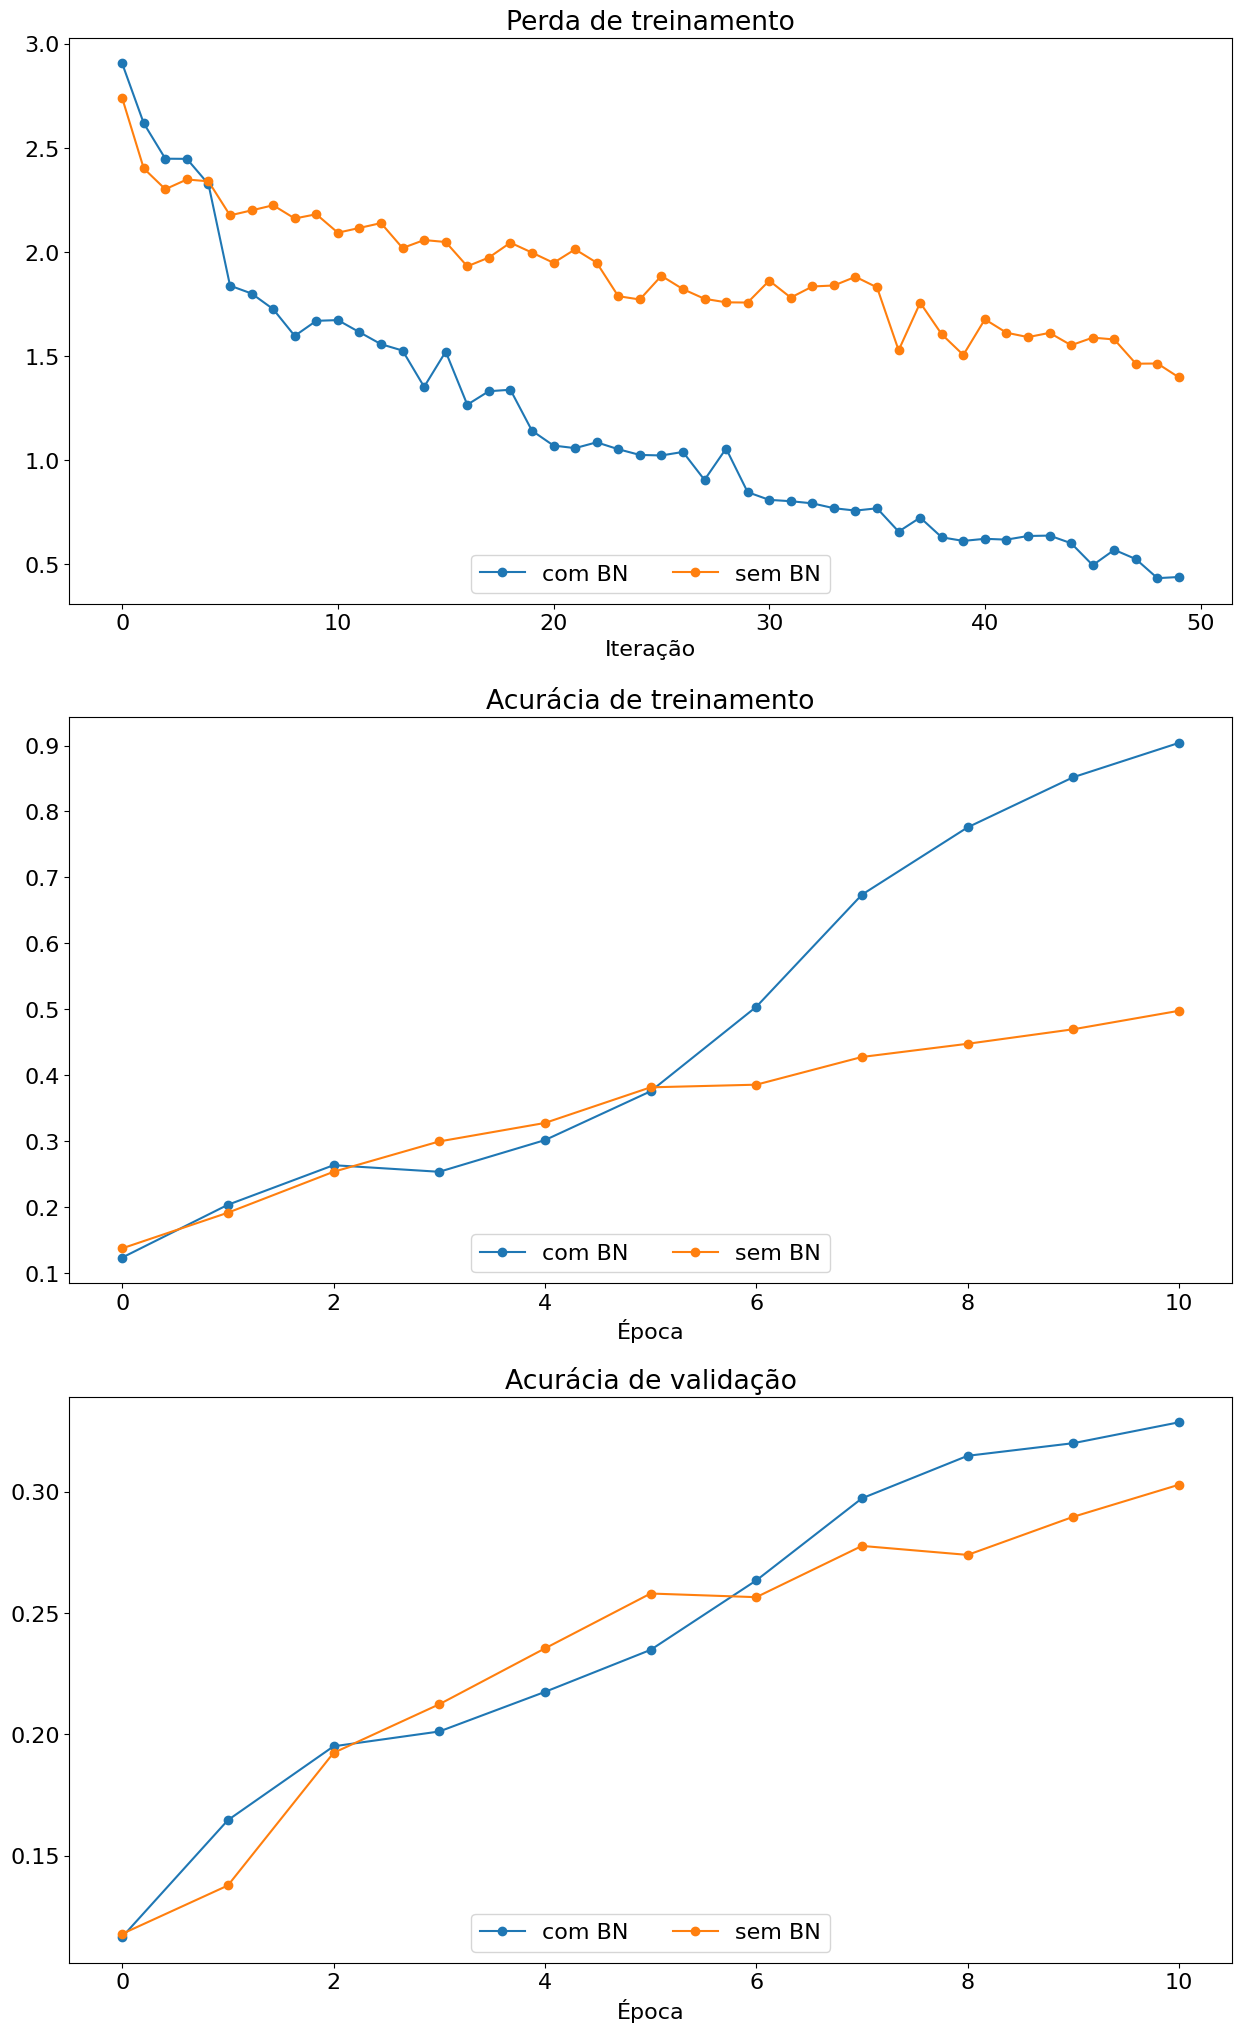

In [29]:
def plotar_historico_treinamento_nl(titulo, eixo_x, solucionadores_sem_nl, solucionadores_com_nl, fn_plot, marcador_sem_nl='.', marcador_com_nl='.', legendas=None):
  """função auxiliar para plotar o histórico de treinamento"""
  plt.title(titulo)
  plt.xlabel(eixo_x)
  plots_com_nl = [fn_plot(solucionador_com_nl) for solucionador_com_nl in solucionadores_com_nl]
  plots_sem_nl = [fn_plot(solucionador_sem_nl) for solucionador_sem_nl in solucionadores_sem_nl]
  num_com_nl = len(plots_com_nl)
  num_sem_nl = len(plots_sem_nl)
  for i in range(num_com_nl):
    label='com BN'
    if legendas is not None:
      label += str(legendas[i])
    plt.plot(plots_com_nl[i], marcador_com_nl, label=label)
  for i in range(num_sem_nl):
    label='sem BN'
    if legendas is not None:
      label += str(legendas[i])
    plt.plot(plots_sem_nl[i], marcador_sem_nl, label=label)
  plt.legend(loc='lower center', ncol=num_com_nl+num_sem_nl)

plt.subplot(3, 1, 1)
plotar_historico_treinamento_nl('Perda de treinamento','Iteração', [solucionador_sem_nl], [solucionador_com_nl], \
                      lambda x: x.historico_perda, marcador_sem_nl='-o', marcador_com_nl='-o')
plt.subplot(3, 1, 2)
plotar_historico_treinamento_nl('Acurácia de treinamento','Época', [solucionador_sem_nl], [solucionador_com_nl], \
                      lambda x: x.historico_acc_treinamento, marcador_sem_nl='-o', marcador_com_nl='-o')
plt.subplot(3, 1, 3)
plotar_historico_treinamento_nl('Acurácia de validação','Época', [solucionador_sem_nl], [solucionador_com_nl], \
                      lambda x: x.historico_acc_validacao, marcador_sem_nl='-o', marcador_com_nl='-o')

plt.gcf().set_size_inches(15, 25)
plt.show()

# Normalização de lote e taxa de aprendizagem
Agora, executaremos um pequeno experimento para estudar a interação da normalização de lote e da taxa de aprendizagem.

A primeira célula treinará redes convolucionais com diferentes taxas de aprendizagem. A segunda célula irá plotar a acurácia do treinamento e a acurácia do conjunto de validação ao longo do tempo. Você deve descobrir que o uso da normalização de lote ajuda a rede a ser menos dependente da taxa de aprendizagem.

In [30]:
from redes_totalmente_conectadas import perda_softmax
from redes_totalmente_conectadas import ConjuntoDeDados
from redes_convolucionais import RedeConvProfunda

redefinir_semente(0)

# Tente treinar uma rede convolucional profunda com normalização de lote
num_treino = 10000
dados_pequeno = {
  'treinamento': ConjuntoDeDados(dic_dados['X_treino'][:num_treino],
                                 dic_dados['y_treino'][:num_treino]),
  'validacao': ConjuntoDeDados(dic_dados['X_val'], dic_dados['y_val']),
}
dims_entrada = dic_dados['X_treino'].shape[1:]
num_epocas = 5
txs = [2e-1, 1e-1, 5e-2]
txs = [5e-3, 1e-2, 2e-2]

solucionadores_sem_nl = []
for tx in txs:
  print('Sem normalização: taxa de aprendizagem = ', tx)
  modelo = RedeConvProfunda(dims_entrada=dims_entrada,
                            num_classes=10,
                            num_filtros=[8, 8, 8],
                            agrups_max=[0, 1, 2],
                            escala_peso='kaiming',
                            normlote=False)
  otimizador = torch.optim.SGD(modelo.parameters(), lr=tx,
                               weight_decay=1e-5, momentum=0.9)
  solucionador = Solucionador(modelo, perda_softmax, otimizador, dados_pequeno,
                          num_epocas=num_epocas, tamanho_lote=100,
                          verbose=False, device='cuda'
                      )
  solucionador.treinar()
  solucionadores_sem_nl.append(solucionador)

solucionadores_com_nl = []
for tx in txs:
  print('Com normalização: taxa de aprendizagem = ', tx)
  modelo = RedeConvProfunda(dims_entrada=dims_entrada,
                            num_classes=10,
                            num_filtros=[8, 8, 8],
                            agrups_max=[0, 1, 2],
                            escala_peso='kaiming',
                            normlote=True)
  otimizador = torch.optim.SGD(modelo.parameters(), lr=tx,
                               weight_decay=1e-5, momentum=0.9)
  solucionador = Solucionador(modelo, perda_softmax, otimizador, dados_pequeno,
                          num_epocas=num_epocas, tamanho_lote=100,
                          verbose=False, device='cuda'
                      )
  solucionador.treinar()
  solucionadores_com_nl.append(solucionador)

Sem normalização: taxa de aprendizagem =  0.005
Sem normalização: taxa de aprendizagem =  0.01
Sem normalização: taxa de aprendizagem =  0.02
Com normalização: taxa de aprendizagem =  0.005
Com normalização: taxa de aprendizagem =  0.01
Com normalização: taxa de aprendizagem =  0.02


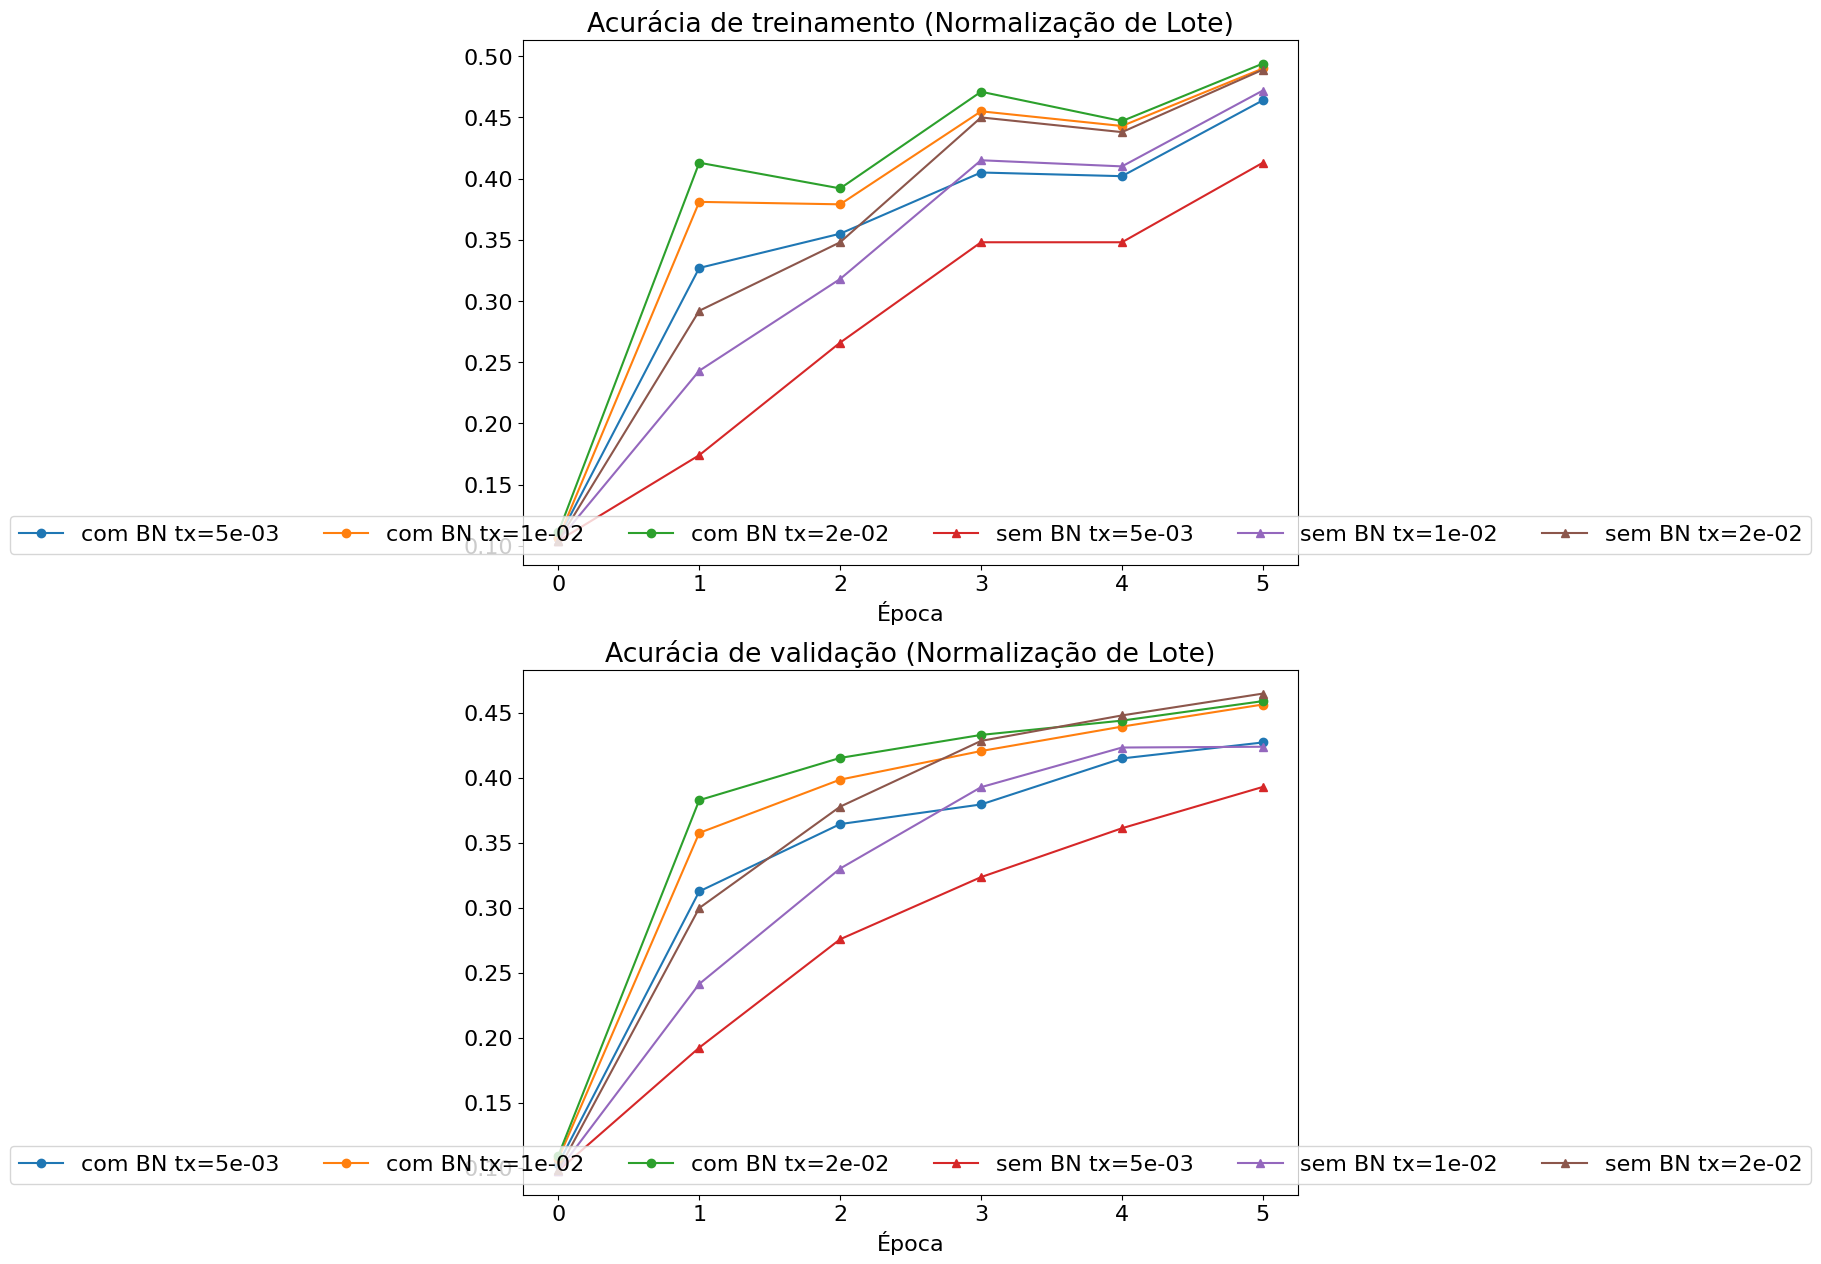

In [31]:
plt.subplot(2, 1, 1)
plotar_historico_treinamento_nl('Acurácia de treinamento (Normalização de Lote)','Época', solucionadores_sem_nl, solucionadores_com_nl, \
                      lambda x: x.historico_acc_treinamento, marcador_sem_nl='-^', marcador_com_nl='-o', legendas=[' tx={:.0e}'.format(tx) for tx in txs])
plt.subplot(2, 1, 2)
plotar_historico_treinamento_nl('Acurácia de validação (Normalização de Lote)','Época', solucionadores_sem_nl, solucionadores_com_nl, \
                      lambda x: x.historico_acc_validacao, marcador_sem_nl='-^', marcador_com_nl='-o', legendas=[' tx={:.0e}'.format(tx) for tx in txs])

plt.gcf().set_size_inches(10, 15)
plt.show()

# Envie seu trabalho
Depois de concluir os dois notebooks para esta tarefa (`redes_totalmente_conectadas.ipynb` e este notebook, `redes_convolucionais.ipynb`), execute a seguinte célula para criar um arquivo `.zip` para você baixar e entregar.

**SALVE MANUALMENTE cada arquivo `*.ipynb` e `*.py` antes de executar a seguinte célula:**


In [32]:
from pi.submit import make_t2_submission

# TODO: Substitua-os pelo seu nome e RA
nome = 'Sergio'
ra = 801814

make_t2_submission(GOOGLE_DRIVE_PATH, nome, ra)

Gravando arquivo zip em:  drive/My Drive/PI-2024-1/T2/Sergio_801814_T2.zip
